Рассмотрим работу с линейной регрессией в библиотеке sklearn. Воспользуемся классами с различным типом регуляризации и подберем оптимальные гиперпараметры для этих моделей. Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Первым делом необходимо скачать данные. Воспользуйтесь следующей инструкцией: [Как скачать данные с kaggle в colab.](https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8) Ниже есть необходимый код, вам нужно лишь запрость токен на kaggle и загрузить его.

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c nyc-taxi-trip-duration

In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration

In [74]:
# imports
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

Распакуем данные, которые мы загрузили. Работать будем только с train частью, так как там имеются значения предсказываемой переменной.

In [75]:
df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и т.д. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

In [76]:
df = df.drop('dropoff_datetime', axis=1)
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Сейчас даты записаны в виде строк. Давайте преобразуем их в питонячие datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

In [77]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получиться. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [78]:
df = df.sort_values(by='pickup_datetime')
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [79]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]
df.shape

(1458644, 10)

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на target переменную.

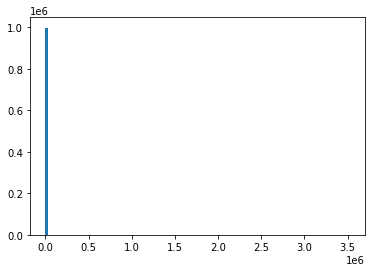

In [80]:
df_train.trip_duration.hist(bins=100, grid=False, );

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мнгновенно завершились. 

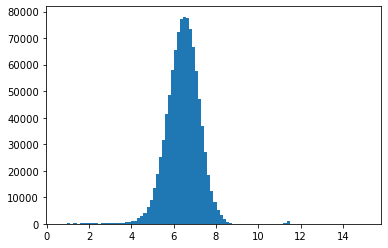

In [81]:
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, );

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [82]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)
df_train.head()

/tmp/ipykernel_30525/65449089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
/tmp/ipykernel_30525/65449089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849,6.745236
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294,7.166266
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408,6.013715
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280,5.638355
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736,6.602588


In [83]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
# again cast?

Посмотрим на наши признаки. Давайте нарисуем, как выглядит распределение количества поездок по дням.

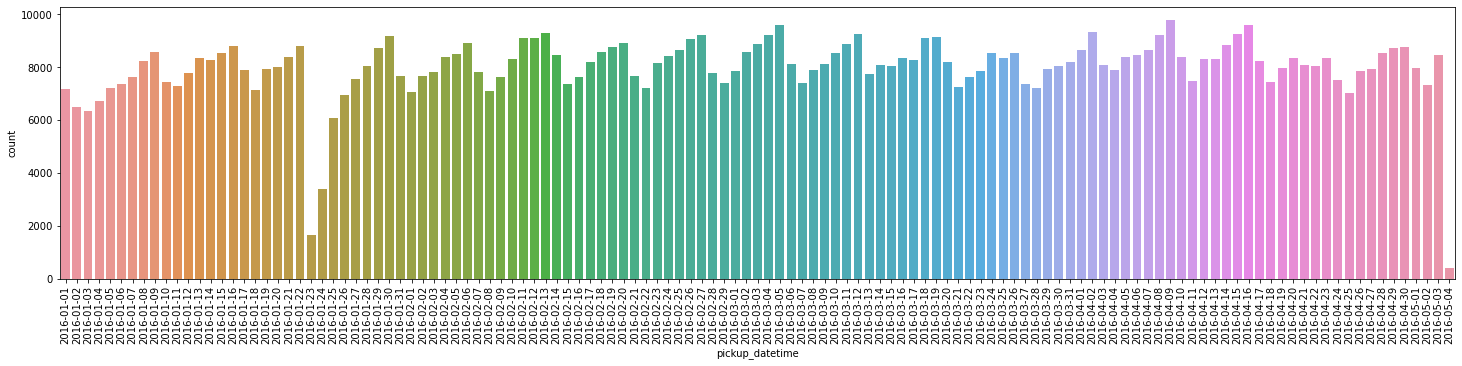

In [84]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

/home/kirilltobola/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


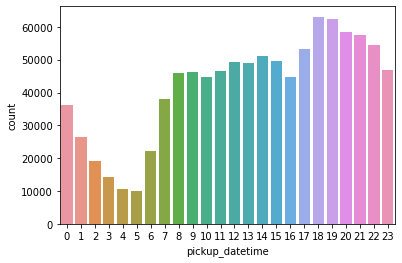

In [85]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
);

Теперь давайте посмотрим, как связан день и длина поездки.

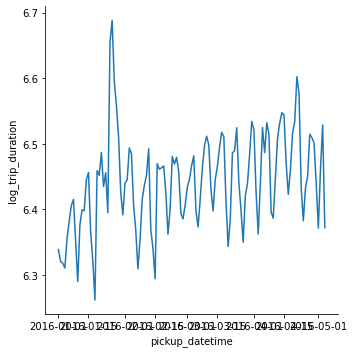

In [86]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.apply(lambda x: x.date()))
rel_plot = sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');
rel_plot

Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `create_features`, которая будет собирать нам нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией, как для train подвыборки, так и для test.

In [87]:
def create_features(data_frame):
    X = pd.concat([
            data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday), # tm_wday
            data_frame.pickup_datetime.apply(lambda x: x.hour),
        ], axis=1, keys=['day', 'hour', 'week_day']
    )
    return X, data_frame.log_trip_duration

In [88]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве.

In [89]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [90]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)
X_train

array([[  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.],
       [  0.,   0.,   0., ...,   0.,   0., 125.]])

Воспользуемся классом `Ridge` и обучим модель.

In [91]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [92]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760845

Давайте попробуем сделать лучше и подберем гиперпараметры модели.

In [93]:
grid_searcher = GridSearchCV(
    Ridge(),
    param_grid={'alpha': np.linspace(100, 750, 10)},
    cv=5
).fit(X_train, y_train)

In [94]:
mean_squared_error(grid_searcher.predict(X_test), y_test)

0.6538784861219814

In [95]:
grid_searcher.best_params_

{'alpha': 388.8888888888889}

# Задание 1
Постройте график, соответствующий количеству поездок в зависимости от дня недели по обучающей выборке.


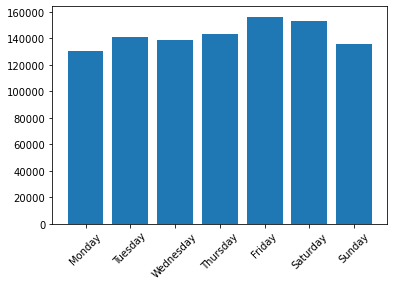

In [96]:
group_by_weekday = df_train.groupby(
    df_train.pickup_datetime.apply(lambda x: x.timetuple().tm_wday)
)
data = group_by_weekday.size()
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = data.values
plt.xticks(rotation = 45)
plt.bar(x, y);

# Задание 2
Добавьте к признакам бинарную переменную, которая равна 1 для двух аномальных дней и 0 во все остальные дни.
Для этого вам понадобится модифицировать функцию create_features.

In [97]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()
day1 = date_sorted.value_counts().keys()[-1]
day2 = date_sorted.value_counts().keys()[-2]

# Добавил в следующей ячейке

# Задание 3
1. Добавьте день недели в качестве признака для обучения. Удобнее всего - модифицировать функцию create_features.

2. Заново проведите one-hot кодирование. Сколько признаков у вас получилось?

In [98]:
def create_features_modified(data_frame):
    X = pd.concat(
        [
            data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
            data_frame.pickup_datetime.apply(lambda x: x.hour),
            data_frame.pickup_datetime.apply(lambda x: x.date() == day1 or x.date() == day2).astype(int),
            data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_wday),
        ], 
        axis=1, 
        keys=['day', 'hour', 'anomaly', 'week_day'],
    )
    return X, data_frame.log_trip_duration


X_train, y_train = create_features_modified(df_train)
X_test, y_test = create_features_modified(df_test)

X_train

,day,hour,anomaly,week_day
96469,1,0,0,4
223872,1,0,0,4
713067,1,0,0,4
652463,1,0,0,4
722901,1,0,0,4
...,...,...,...,...
1384418,125,3,1,2
1100978,125,3,1,2
630885,125,3,1,2
567651,125,3,1,2


In [99]:
ohe = ColumnTransformer(
    [
        ("One hot", OneHotEncoder(sparse=False), ['hour', 'week_day', 'anomaly'])
    ],
    remainder="passthrough"
)

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,125.0
999996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,125.0
999997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,125.0
999998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,125.0


# Задание 4

1. Отмасштабируйте единственный вещественный признак.
2. Обучите на полученных данных Lasso регрессию, в качества параметра  `alpha` возьмите 2.65e-05.

Какое качество в терминах MSE вы получили?

Сколько признаков было отобрано? В качестве критерия зануления признака используйте сравнение с $10^{-6}$ (с точностью до 3 знаков после запятой).



In [100]:
ct = ColumnTransformer([
    ('z', StandardScaler(), [33])
], remainder="passthrough")

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-1.776795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.776795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.776795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.776795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.776795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.731355,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
999996,1.731355,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
999997,1.731355,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
999998,1.731355,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [101]:
alpha = 2.65e-05
lasso = Lasso(alpha=alpha).fit(X_train, y_train)
mse = mean_squared_error(lasso.predict(X_test), y_test)

In [109]:
print(f'mse = {mse}', end='\n\n')

rejected = sum(
    abs(lasso.coef_) < 1e-6
)
print(f'общее количество признаков = {len(lasso.coef_)}')
print(f'обнуленные признаки = {rejected}')

mse = 0.6504516429935406

общее количество признаков = 34
обнуленные признаки = 3
